# Inferential Statistics: 
## Are there significant differences between the people who survived and those who didn't?

Let's load in the titanic dataset that was discussed in [lecture 11](L11_viz.ipynb) Because this is an incomplete passenger log, it is is a sampling of the population of passengers on the Titanic.

In [3]:

import pandas as pd
dataurl = "https://raw.githubusercontent.com/story645/dhworkbooks/master/data/titanicfull.csv"
df = pd.read_csv(dataurl)

In [4]:
# printing the first 2 rows
df.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


We are looking for the differences between people who survived and people who died, so first let's get a count of the two groups using the `.value_count()` method on the `applied` column.
* 0 = Died
* 1 = Survived

In [5]:
#let's see who died
df['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

# In what ways do can we see how the groups differ?

We can get a list of columns using the `.columns` attribute of the dataframe.

In [6]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

Let's also see the datatypes to learn which columns are quantative and which are qualitative because the statistical approaches will differ. We use the `.info()` method to learn this information.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


# Is there a statistical difference in the ages between the two groups?

We use `.groupby` to split the data into the died and survived groups, and then we use `.describe` to compute the descriptive statistics on each group. 

In [83]:
df.groupby('survived')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
survived,,,,,,,,
0,619.0,30.545363,13.922550,0.33,21.0,28.0,39.0,74.0
1,427.0,28.918244,15.061452,0.17,20.0,28.0,38.0,80.0


Let's set up some clearer labels and consistent colors for our two groups. Because the group names are the integers 0 and 1, we will directly map the indexes 0 and 1 to the name and color we intend to use for the groups. 

In [63]:
labels = ['died', 'survived']
colors = ['gray', 'green'] 

In [65]:
labels[0], colors[0]

('died', 'gray')

Let's plot the ages. We first sort the ages so that the ages are ordered; this is called an [ecdf](https://en.wikipedia.org/wiki/Empirical_distribution_function) plot and is used to show the range and count of ages in the samples we have.

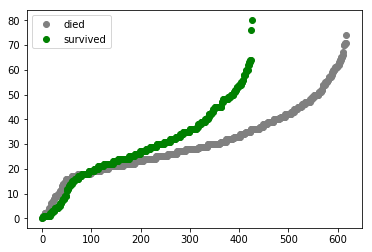

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for (gname, group) in df.groupby('survived'):
    _ = ax.plot(group['age'].sort_values().values, 'o', color=colors[gname], label=labels[gname])
_ = ax.legend()

But about 200 more people died than survived, and the above plot doesn't take that into consider. So lets make a plot that lets us compare the two. 

One method is to plot the normalized histogram, which is a binned count of the data that's then divided by the total number of elements in each group. This gives us the probability of someone in the population being that age. Then we plot the [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), which is another way of estimating the probability of any random person in the population being that age. These graphs are two ways of displaying the distribution of the data, which is the probability (y axis) of any random person being any age (x axis).

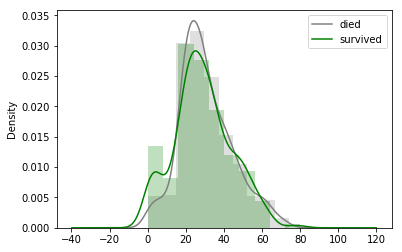

In [97]:
fig, ax = plt.subplots()
for (gname, group) in df.groupby('survived'):   
    _ = group['age'].hist(ax=ax, density=True, color=colors[gname], alpha=.25)
    _ = group['age'].plot.kde(ax=ax, color=colors[gname], label=labels[gname])
_ = ax.legend()

# Let's use a statistical test to check if these distributions are different?

We're gonna use a two new Python library for statistics to get more sophisticated tests:
* [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html) - simple stats
* [statsmodels](http://www.statsmodels.org/dev/stats.html#module-statsmodels.stats) - complex stats

In [68]:
import scipy.stats as st

Let's get our two groups again. One way to do this is that `.groupby` yields a (name, dataframe) pair that we can wrap in a dictionary: 

In [88]:
passengers = dict(list(df.groupby('survived')))

In [90]:
passengers[0].head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.55,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"


And now let's try a [two sample t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy-stats-ttest-ind) on the group:
```python
     scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='omit')[source]
```
We use nan_policy='omit' to tell the program to ignore observations that are missing measurements. 

In [95]:
st.ttest_ind(passengers[0]['age'], passengers[1]['age'], nan_policy='omit')

Ttest_indResult(statistic=1.7964123280752857, pvalue=0.0727179715824039)

## How do we interpret a t-test? 
1. We look up the expected t-value in a [t-value table](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3672.htm)
 * degrees of freedom = independent observations in the dataset/sample size - 1
 * confidence level = probability of the data distribution not being due to chance
 
2. We compare this T value to ours, and if our T is larger than the table-T, we reject the null hypothesis (meaning that the two populations are statistically different). 

3. We check that the p-value is larger than $\alpha$, which is 1-confidence level. 
 

# Are these populations different?
In our case, degrees of freedom  are basically $\infty$ & lets set confidence to 95%. This yields ` T=1.65`


# Challenge
Are these two populations statistically different in other ways? Try the above with a different variables. 

# How about if we want to see if there are differences in sex between the groups?

First let's get a count of our data broken down by the categories we are interest in, which are `survived` and `sex`. We use the `groupby` method as above, but this time we pass in a list of variables we want to group by. We then use `count` to find the frequency. 

In [106]:
df.groupby(['survived','sex']).count()

pclass  name  age  sibsp  parch  ticket  fare  cabin  \
survived sex                                                            
0        female     127   127   96    127    127     127   127      8   
         male       682   682  523    682    682     682   681     94   
1        female     339   339  292    339    339     339   339    133   
         male       161   161  135    161    161     161   161     60   

                 embarked  boat  body  home.dest  
survived sex                                      
0        female       127     1     8         47  
         male         682     8   113        351  
1        female       337   318     0        241  
         male         161   159     0        106

Let's use `.info()` to check which of our columns are missing data. Since we have 1309 records, a non missing variable has 1309 records. Lets use the count from names for the sake of simplicity. We use unstack to put the data into a table, and use xticklabels to label the data with the proper names instead of 0 and 1.

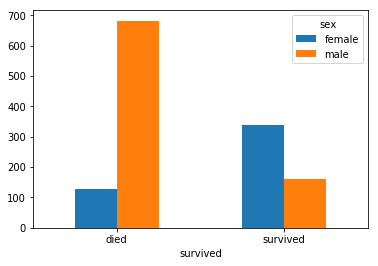

In [119]:
fig, ax = plt.subplots()
_ = df.groupby(['survived','sex'])['name'].count().unstack().plot.bar(ax=ax)
_ = ax.set_xticklabels(["died", "survived"], rotation=0)

# How do we test if this difference is statistically significant?

We can use a [chi-square](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm) which tests whether a given distribution of frequencies lines up with an expected distribution. In this case, we treat one of our groups as expected and the other as observed. We use the [chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency) function because it provides some extra information.

```python
scipy.stats.chi2_contingency(observed, correction=True, lambda_=None)
```

Let's use groupby again to get the frequencies. 

In [146]:
df.groupby(['survived','sex']).count().unstack()['name']

sex,female,male
survived,,
0,127,682
1,339,161


In [147]:
df.groupby(['survived','sex']).count().unstack()['name'].values

array([[127, 682],
       [339, 161]])

In [145]:
st.chi2_contingency(df.groupby(['survived','sex']).count().unstack()['name'].values)

(363.6179084388249,
 4.589924936952945e-81,
 1,
 array([[288.00152788, 520.99847212],
        [177.99847212, 322.00152788]]))

# How do we interpret the chi-square test?? 
1. The function returned the following:
    * chi2: The test statistic.
    * p: The p-value of the test
    * dof: Degrees of freedom
    * expected: The expected frequencies, based on the marginal sums of the table.
2. We look up the critical values in the (chi-square table)(https://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm)
 * degrees of freedom = number of classes in each category - 1
     * 2 survived classes - 0/1
     * 2 sex classes - male/female
     * df = (2-1) X (2-1)
 * confidence level = probability of the data distribution not being due to chance
3. We compare the value from the table to ours. 
4. We check that the p-value is larger than $\alpha$, which is 1-confidence level. 

# Challenge
Repeat the above with a different categorical variable.

# Project
Apply a method from either your statistics or experimental psychology that hasn't been mentioned to this data to test which variables are different between the two populations. 